# 🤖 Sistema Híbrido de Detección de Sexismo - EXIST2025

## Componentes del Sistema

### 1. Conexión con Decoupled AI (LLM Remote)
- **Modelo**: Mistral-Nemo via Decoupled AI
- **Uso**: Análisis contextual avanzado para las 3 subtareas EXIST2025

### 2. Sistema de Prompts Especializados  
- **Subtask 1.1**: Detección binaria de sexismo
- **Subtask 1.2**: Análisis de intención (DIRECT/REPORTED/JUDGEMENTAL)
- **Subtask 1.3**: Categorización multilabel (5 categorías)

### 3. Arquitectura Híbrida (SUBTASK 1.1 , 1.2)
- **Local**: Transformer XML-ROBERTA-LARGE 
- **Remoto**: LLM Mistral-Nemo para comprensión contextual
- **Fusión**: Ensemble adaptativo basado en confianza


**USANDO DECOPLED

In [36]:
import json
import requests
from ollama import Client


def prompt_decoupled(query, model='mistral-nemo:latest', context=[]):

    host = 'https://ollama01.decoupled.ai'
    # host = 'http://localhost:11434'

    payload = {
        "prompt": query,
        "model": model,
        "stream": False,
        "context": context,
        "keep_alive": "1h"
    }

    try:
        messages = []
        message = {}
        message['role'] = "user" # system, assistant, user
        message['content'] = query
        messages.append(message)

        res = {}

        #res['response'], model = decoupled_rest(model, host, messages)
        res['response'], model = decoupled_python(model, host, messages)

        input_token_count = token_count(query)
        output_token_count = token_count(res['response'])

        if res['response'] is not None and res['response'] != '':
            return res, model, input_token_count, output_token_count
        else:
            print("EXCEPTION RES")
            return None, model, 0, 0

    except Exception as e:
        print("EXCEPTION: ", str(e))
        return None, model, 0, 0


def decoupled_rest(model, url, payload):
    headers = {
        "Content-Type": "application/json"
    }

    res = requests.post(url, headers=headers, data=json.dumps(payload), timeout=120)

    if res.status_code == 200:
        return res.text, model
    else:
        return None, model


def decoupled_python(model, url, messages):

    client = Client(host=url, timeout=120)
    response = client.chat(model=model, messages=messages, keep_alive="168h")

    return response['message']['content'], model


def token_count(phrase):
    tokens = 0

    for s in phrase:
        if '\n' in s or \
                '\t' in s or \
                ' ' in s:
            tokens += 1

    words = phrase.split()

    for word in words:
        count = syllable_count(word)
        tokens += count

    if tokens == 0:
        tokens = 1

    return tokens


def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiou"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if count == 0:
        count += 1
    return count


In [ ]:
# 🔧 FUNCIONES MODULARES PARA EXIST2025 - VERSIÓN OPTIMIZADA

class EXIST2025PromptBuilder:
    """
    Clase optimizada para construir prompts de EXIST2025 de forma modular y mantenible
    """
    
    def __init__(self, language="es"):
        self.language = language.lower()
        self.definitions = self._load_definitions()
        self.examples = self._load_examples()
        self.categories = self._load_categories()
    
    def _load_definitions(self):
        """Carga las definiciones base según el idioma"""
        if self.language == "es":
            return {
                "sexism": "Prejuicio, estereotipo o discriminación, típicamente contra las mujeres, basado en el sexo",
                "key_question": "¿Es el tweet sexista de alguna forma, o describe situaciones donde ocurre discriminación?",
                "intention_question": "¿Cuál es la intención de la persona que escribió el tweet?",
                "categories_question": "Identifica QUÉ TIPO(S) de sexismo contiene este tweet:"
            }
        else:
            return {
                "sexism": "Prejudice, stereotyping, or discrimination, typically against women, on the basis of sex",
                "key_question": "Is the tweet sexist in any form, or does it describe situations where discrimination occurs?",
                "intention_question": "What do you think the intention of the person that wrote the tweet is?",
                "categories_question": "Identify WHAT TYPE(S) of sexism this tweet contains:"
            }
    
    def _load_examples(self):
        """Carga los ejemplos según el idioma"""
        if self.language == "es":
            return {
                "sexist": [
                    "Es menos un #díasinmujeres y más un día sin feministas, lo cual suena encantador",
                    "Las mujeres no pueden manejar, llámame sexista pero es verdad",
                    "Te ves como una puta con esos pantalones - Mi hermano cuando me vio"
                ],
                "non_sexist": [
                    "¿Dónde están todas las mujeres blancas?",
                    "El video impactante de una mujer al volante que escapa milagrosamente",
                    "¿No te convencen mis argumentos? Intentemos debatir"
                ],
                "forms": {
                    "AMIGABLE": "Las mujeres deben ser amadas y respetadas, trátelas como cristal frágil",
                    "DIVERTIDO": "Tienes que amar a las mujeres... solo eso... nunca las entenderás",
                    "OFENSIVO": "Te ves como una puta con esos pantalones",
                    "VIOLENTO": "Humíllate y degrádate como la perra que eres"
                }
            }
        else:
            return {
                "sexist": [
                    "It's less of #adaywithoutwomen and more of a day without feminists, which sounds lovely",
                    "I'm sorry but women cannot drive, call me sexist but it is true",
                    "You look like a whore in those pants - My brother when he saw me"
                ],
                "non_sexist": [
                    "Where all the white women at?",
                    "The shocking video of a woman at the wheel who miraculously escapes",
                    "Don't my arguments convince you? Let's try to debate"
                ],
                "forms": {
                    "FRIENDLY": "Women must be loved and respected, always treat them like fragile glass",
                    "FUNNY": "You have to love women... just that... You will never understand them",
                    "OFFENSIVE": "You look like a whore in those pants",
                    "VIOLENT": "Humiliate, expose and degrade yourself as the fucking bitch you are"
                }
            }
    
    def _load_categories(self):
        """Carga las categorías de sexismo según el idioma"""
        if self.language == "es":
            return {
                "IDEOLOGICAL-INEQUALITY": {
                    "name": "Descrédito ideológico, negación de desigualdad",
                    "description": "Desacredita movimiento feminista para devaluar lucha de mujeres",
                    "examples": ["#El feminismo es una guerra contra los hombres", "La igualdad se está saliendo de control"]
                },
                "STEREOTYPING-DOMINANCE": {
                    "name": "Estereotipos de roles y dominancia",
                    "description": "Ideas falsas sobre capacidades de mujeres para ciertas tareas",
                    "examples": ["Las mujeres ya no tienen deseo de desarrollar carácter", "Mujer al volante, ¡cuidado!"]
                },
                "OBJECTIFICATION": {
                    "name": "Objetificación y estereotipos físicos",
                    "description": "Presenta mujeres como objetos sin dignidad",
                    "examples": ["Solo quiero mujeres para sexo", "Nunca he visto una prostituta atractiva"]
                },
                "SEXUAL-VIOLENCE": {
                    "name": "Violencia sexual",
                    "description": "Sugerencias sexuales, solicitudes de favores sexuales",
                    "examples": ["Quiero tocar tus pechos... no puedes imaginar lo que puedo hacer"]
                },
                "MISOGYNY-NON-SEXUAL-VIOLENCE": {
                    "name": "Misoginia y violencia no sexual",
                    "description": "Expresiones de odio y violencia hacia mujeres",
                    "examples": ["Algunas mujeres son tan tóxicas", "El abuso doméstico... a menos que tu esposa sea una perra"]
                }
            }
        else:
            return {
                "IDEOLOGICAL-INEQUALITY": {
                    "name": "Ideological discredit, denying inequality",
                    "description": "Discredits feminist movement to devalue women's struggle",
                    "examples": ["#Feminism is a war on men", "The whole equality thing is getting out of hand"]
                },
                "STEREOTYPING-DOMINANCE": {
                    "name": "Role stereotyping and dominance",
                    "description": "False ideas about women's capabilities for certain tasks",
                    "examples": ["Most women no longer have the desire to develop character", "Woman driving, be careful!"]
                },
                "OBJECTIFICATION": {
                    "name": "Objectification and physical stereotyping",
                    "description": "Presents women as objects without dignity",
                    "examples": ["I just want women for sex", "I've never seen an attractive hooker"]
                },
                "SEXUAL-VIOLENCE": {
                    "name": "Sexual violence",
                    "description": "Sexual suggestions, requests for sexual favors",
                    "examples": ["I wanna touch your tits...you can't imagine what I can do"]
                },
                "MISOGYNY-NON-SEXUAL-VIOLENCE": {
                    "name": "Misogyny and non-sexual violence",
                    "description": "Expressions of hatred and violence towards women",
                    "examples": ["Some women are so toxic", "Domestic abuse... Unless your wife is a bitch"]
                }
            }
    
    def build_header(self, subtask, tweet):
        """Construye el header del prompt"""
        task_names = {
            "1.1": "Detección Binaria de Sexismo" if self.language == "es" else "Binary Sexism Detection",
            "1.2": "Intención del Emisor" if self.language == "es" else "Author's Intention",
            "1.3": "Categorías de Sexismo (Multilabel)" if self.language == "es" else "Sexism Categories (Multilabel)"
        }
        
        return f'''EXIST2025 - Subtask {subtask}: {task_names[subtask]}

{"Analiza el siguiente tweet según los criterios oficiales de EXIST2025:" if self.language == "es" else "Analyze the following tweet according to official EXIST2025 criteria:"}

TWEET: "{tweet}"
'''
    
    def build_binary_prompt(self, tweet):
        """Construye prompt para subtask 1.1"""
        header = self.build_header("1.1", tweet)
        
        if self.language == "es":
            content = f'''
PREGUNTA CLAVE: {self.definitions["key_question"]}

DEFINICIÓN SEXISMO (Oxford Dictionary + EXIST2025):
"{self.definitions["sexism"]}"

INCLUYE (Clasifica como YES):
• Tweet sexista por sí mismo
• Tweet que describe una situación sexista
• Tweet que critica un comportamiento sexista

FORMAS DE SEXISMO A DETECTAR:
🔹 AMIGABLE: "{self.examples["forms"]["AMIGABLE"]}"
🔹 DIVERTIDO: "{self.examples["forms"]["DIVERTIDO"]}"
🔹 OFENSIVO: "{self.examples["forms"]["OFENSIVO"]}"
🔹 VIOLENTO: "{self.examples["forms"]["VIOLENTO"]}"

EJEMPLOS SEXISTAS (YES):
{chr(10).join([f"- {ex}" for ex in self.examples["sexist"]])}

EJEMPLOS NO SEXISTAS (NO):
{chr(10).join([f"- {ex}" for ex in self.examples["non_sexist"]])}

RESPUESTA: Formato JSON con "prediction" (YES/NO) y "confidence" (0.0 a 1.0)
Responde ÚNICAMENTE con el objeto JSON.
Ejemplo: {{"prediction": "YES", "confidence": 0.95}}
'''
        else:
            content = f'''
KEY QUESTION: {self.definitions["key_question"]}

SEXISM DEFINITION (Oxford Dictionary + EXIST2025):
"{self.definitions["sexism"]}"

INCLUDES (Classify as YES):
• Tweet that is sexist itself
• Tweet that describes a sexist situation
• Tweet that criticizes sexist behavior

FORMS OF SEXISM TO DETECT:
🔹 FRIENDLY: "{self.examples["forms"]["FRIENDLY"]}"
🔹 FUNNY: "{self.examples["forms"]["FUNNY"]}"
🔹 OFFENSIVE: "{self.examples["forms"]["OFFENSIVE"]}"
🔹 VIOLENT: "{self.examples["forms"]["VIOLENT"]}"

SEXIST EXAMPLES (YES):
{chr(10).join([f"- {ex}" for ex in self.examples["sexist"]])}

NON-SEXIST EXAMPLES (NO):
{chr(10).join([f"- {ex}" for ex in self.examples["non_sexist"]])}

RESPONSE: JSON format with "prediction" (YES/NO) and "confidence" (0.0 to 1.0)
Respond ONLY with the JSON object.
Example: {{"prediction": "YES", "confidence": 0.95}}
'''
        
        return header + content
    
    def build_intention_prompt(self, tweet):
        """Construye prompt para subtask 1.2"""
        header = self.build_header("1.2", tweet)
        
        intentions = {
            "es": {
                "DIRECT": {
                    "desc": "La intención es escribir un mensaje sexista por sí mismo",
                    "example": "Una mujer necesita amor, llenar la nevera, si un hombre puede darle esto a cambio de sus servicios (tareas domésticas, cocina, etc), no veo qué más necesita"
                },
                "REPORTED": {
                    "desc": "La intención es reportar o describir una situación sexista sufrida por una mujer (primera o tercera persona)",
                    "example": "Me duermo en el metro, abro los ojos sintiendo algo raro: la mano del hombre sentado a mi lado en mi pierna #DenunciaATuCerdo"
                },
                "JUDGEMENTAL": {
                    "desc": "La intención es ser crítico, describiendo situaciones sexistas con el objetivo de condenarlas",
                    "example": "Como siempre, la mujer fue quien dejó su trabajo por el bienestar de la familia"
                }
            },
            "en": {
                "DIRECT": {
                    "desc": "The intention is to write a message that is sexist by itself",
                    "example": "A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don't see what else she needs"
                },
                "REPORTED": {
                    "desc": "The intention is to report or describe a sexist situation or event suffered by a woman (first or third person)",
                    "example": "I doze in the subway, I open my eyes feeling something weird: the hand of the man sat next to me on my leg #SquealOnYourPig"
                },
                "JUDGEMENTAL": {
                    "desc": "The intention is to be judgemental, describing sexist situations or behaviors with the aim to condemning them",
                    "example": "As usual, the woman was the one quitting her job for the family's welfare"
                }
            }
        }
        
        lang_intentions = intentions[self.language]
        
        if self.language == "es":
            content = f'''
PREGUNTA: {self.definitions["intention_question"]}

OPCIONES DE INTENCIÓN:

🔹 DIRECT: {lang_intentions["DIRECT"]["desc"]}
Ejemplo: "{lang_intentions["DIRECT"]["example"]}"

🔹 REPORTED: {lang_intentions["REPORTED"]["desc"]}
Ejemplo: "{lang_intentions["REPORTED"]["example"]}"

🔹 JUDGEMENTAL: {lang_intentions["JUDGEMENTAL"]["desc"]}
Ejemplo: "{lang_intentions["JUDGEMENTAL"]["example"]}"

RESPUESTA: DIRECT, REPORTED o JUDGEMENTAL
Responde ÚNICAMENTE: DIRECT, REPORTED o JUDGEMENTAL
'''
        else:
            content = f'''
QUESTION: {self.definitions["intention_question"]}

INTENTION OPTIONS:

🔹 DIRECT: {lang_intentions["DIRECT"]["desc"]}
Example: "{lang_intentions["DIRECT"]["example"]}"

🔹 REPORTED: {lang_intentions["REPORTED"]["desc"]}
Example: "{lang_intentions["REPORTED"]["example"]}"

🔹 JUDGEMENTAL: {lang_intentions["JUDGEMENTAL"]["desc"]}
Example: "{lang_intentions["JUDGEMENTAL"]["example"]}"

RESPONSE: DIRECT, REPORTED or JUDGEMENTAL
Respond ONLY: DIRECT, REPORTED or JUDGEMENTAL
'''
        
        return header + content
    
    def build_categories_prompt(self, tweet):
        """Construye prompt para subtask 1.3"""
        header = self.build_header("1.3", tweet)
        
        if self.language == "es":
            content = f'''
{self.definitions["categories_question"]}

CATEGORÍAS POSIBLES (puede ser una o varias):

'''
            for cat_id, cat_info in self.categories.items():
                content += f'''🔹 {cat_id}: {cat_info["name"]}
- {cat_info["description"]}
Ejemplos: {" / ".join(cat_info["examples"])}

'''
            
            content += '''RESPUESTA: Lista las categorías aplicables separadas por comas
Responde con las categorías que aplican, ejemplo: IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINANCE
'''
        else:
            content = f'''
{self.definitions["categories_question"]}

POSSIBLE CATEGORIES (can be one or several):

'''
            for cat_id, cat_info in self.categories.items():
                content += f'''🔹 {cat_id}: {cat_info["name"]}
- {cat_info["description"]}
Examples: {" / ".join(cat_info["examples"])}

'''
            
            content += '''RESPONSE: List applicable categories separated by commas
Respond with the categories that apply, example: IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINANCE
'''
        
        return header + content
    
    def build_prompt(self, tweet, subtask="1.1"):
        """Método principal para construir prompts"""
        if subtask == "1.1":
            return self.build_binary_prompt(tweet)
        elif subtask == "1.2":
            return self.build_intention_prompt(tweet)
        elif subtask == "1.3":
            return self.build_categories_prompt(tweet)
        else:
            raise ValueError(f"Subtask '{subtask}' no válida. Use '1.1', '1.2', o '1.3'")


# 🚀 FUNCIÓN OPTIMIZADA CON LA NUEVA CLASE
def build_prompt_sexism_detection(post, subtask="1.1", language="es"):
    """
    Función optimizada para construir prompts de EXIST2025
    
    Args:
        post (str): El texto del tweet a analizar
        subtask (str): "1.1" (binario), "1.2" (intención), "1.3" (categorías)
        language (str): El idioma del análisis ("es" para español, "en" para inglés)
    
    Returns:
        str: Prompt formateado según la subtarea específica
    """
    builder = EXIST2025PromptBuilder(language)
    return builder.build_prompt(post, subtask)



In [38]:
# Ejemplo de uso con la nueva lógica de clases

# 1. Crear una instancia del constructor de prompts para español
builder_es = EXIST2025PromptBuilder(language="es")

# 2. Definir el tweet de ejemplo
tweet_ejemplo = "Las mujeres no pueden manejar, llámame sexista pero es verdad"

# 3. Usar el objeto 'builder' para construir el prompt
prompt = builder_es.build_prompt(tweet_ejemplo, subtask="1.1")

# 4. Imprimir el resultado
print("--- PROMPT EN ESPAÑOL (Subtarea 1.1) ---")
print(prompt)

# Ejemplo adicional para inglés (descomentado y corregido)
# print("\n--- PROMPT EN INGLÉS (Subtarea 1.1) ---")
# builder_en = EXIST2025PromptBuilder(language="en")
# prompt_en = builder_en.build_prompt(tweet_ejemplo, subtask="1.1")
# print(prompt_en)


--- PROMPT EN ESPAÑOL (Subtarea 1.1) ---
EXIST2025 - Subtask 1.1: Detección Binaria de Sexismo

Analiza el siguiente tweet según los criterios oficiales de EXIST2025:

TWEET: "Las mujeres no pueden manejar, llámame sexista pero es verdad"

PREGUNTA CLAVE: ¿Es el tweet sexista de alguna forma, o describe situaciones donde ocurre discriminación?

DEFINICIÓN SEXISMO (Oxford Dictionary + EXIST2025):
"Prejuicio, estereotipo o discriminación, típicamente contra las mujeres, basado en el sexo"

INCLUYE (Clasifica como YES):
• Tweet sexista por sí mismo
• Tweet que describe una situación sexista
• Tweet que critica un comportamiento sexista

FORMAS DE SEXISMO A DETECTAR:
🔹 AMIGABLE: "Las mujeres deben ser amadas y respetadas, trátelas como cristal frágil"
🔹 DIVERTIDO: "Tienes que amar a las mujeres... solo eso... nunca las entenderás"
🔹 OFENSIVO: "Te ves como una puta con esos pantalones"
🔹 VIOLENTO: "Humíllate y degrádate como la perra que eres"

EJEMPLOS SEXISTAS (YES):
- Es menos un #díasin

In [39]:
# Llama al modelo decoupled 
respuesta, modelo_usado, tokens_in, tokens_out = prompt_decoupled(prompt, model='mistral-nemo:latest')

In [40]:
print(f"\n📊 RESULTADOS:")
print(f"Modelo usado: {modelo_usado}")
print(f"Tokens de entrada: {tokens_in}")
print(f"Tokens de salida: {tokens_out}")
print(f"Respuesta: {respuesta['response']}")


📊 RESULTADOS:
Modelo usado: mistral-nemo:latest
Tokens de entrada: 721
Tokens de salida: 12
Respuesta: {"prediction": "YES", "confidence": 0.95}


In [41]:
# Probar las otras dos subtareas (1.2 y 1.3) con el tweet de ejemplo

# Subtarea 1.2: Intención del emisor
prompt_1_2 = build_prompt_sexism_detection(tweet_ejemplo, subtask="1.2", language="es")
respuesta_1_2, modelo_usado_1_2, tokens_in_1_2, tokens_out_1_2 = prompt_decoupled(prompt_1_2, model='mistral-nemo:latest')

print("Prompt 1.2 enviado:")
print(prompt_1_2)
print(f"\nRespuesta 1.2:\n{respuesta_1_2['response']}")



Prompt 1.2 enviado:
EXIST2025 - Subtask 1.2: Intención del Emisor

Analiza el siguiente tweet según los criterios oficiales de EXIST2025:

TWEET: "Las mujeres no pueden manejar, llámame sexista pero es verdad"

PREGUNTA: ¿Cuál es la intención de la persona que escribió el tweet?

OPCIONES DE INTENCIÓN:

🔹 DIRECT: La intención es escribir un mensaje sexista por sí mismo
Ejemplo: "Una mujer necesita amor, llenar la nevera, si un hombre puede darle esto a cambio de sus servicios (tareas domésticas, cocina, etc), no veo qué más necesita"

🔹 REPORTED: La intención es reportar o describir una situación sexista sufrida por una mujer (primera o tercera persona)
Ejemplo: "Me duermo en el metro, abro los ojos sintiendo algo raro: la mano del hombre sentado a mi lado en mi pierna #DenunciaATuCerdo"

🔹 JUDGEMENTAL: La intención es ser crítico, describiendo situaciones sexistas con el objetivo de condenarlas
Ejemplo: "Como siempre, la mujer fue quien dejó su trabajo por el bienestar de la familia"


In [42]:
# Subtarea 1.3: Categorías de sexismo
prompt_1_3 = build_prompt_sexism_detection(tweet_ejemplo, subtask="1.3", language="es")
respuesta_1_3, modelo_usado_1_3, tokens_in_1_3, tokens_out_1_3 = prompt_decoupled(prompt_1_3, model='mistral-nemo:latest')

print("\nPrompt 1.3 enviado:")
print(prompt_1_3)
print(f"\nRespuesta 1.3:\n{respuesta_1_3['response']}")


Prompt 1.3 enviado:
EXIST2025 - Subtask 1.3: Categorías de Sexismo (Multilabel)

Analiza el siguiente tweet según los criterios oficiales de EXIST2025:

TWEET: "Las mujeres no pueden manejar, llámame sexista pero es verdad"

Identifica QUÉ TIPO(S) de sexismo contiene este tweet:

CATEGORÍAS POSIBLES (puede ser una o varias):

🔹 IDEOLOGICAL-INEQUALITY: Descrédito ideológico, negación de desigualdad
- Desacredita movimiento feminista para devaluar lucha de mujeres
Ejemplos: #El feminismo es una guerra contra los hombres / La igualdad se está saliendo de control

🔹 STEREOTYPING-DOMINANCE: Estereotipos de roles y dominancia
- Ideas falsas sobre capacidades de mujeres para ciertas tareas
Ejemplos: Las mujeres ya no tienen deseo de desarrollar carácter / Mujer al volante, ¡cuidado!

🔹 OBJECTIFICATION: Objetificación y estereotipos físicos
- Presenta mujeres como objetos sin dignidad
Ejemplos: Solo quiero mujeres para sexo / Nunca he visto una prostituta atractiva

🔹 SEXUAL-VIOLENCE: Violenc

In [43]:
# 🔧 SISTEMA HÍBRIDO: TRANSFORMER + LLM ENSEMBLE

import sys
import torch.nn as nn
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer,AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import json
from typing import Dict, List, Tuple, Optional
import os

import torch

# Detectar si hay una GPU disponible (CUDA) y seleccionarla, de lo contrario, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"🔥 Nombre de la GPU: {torch.cuda.get_device_name(0)}")

✅ Dispositivo seleccionado: cuda
🔥 Nombre de la GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [44]:
# CELDA [38] CORREGIDA

class SoftBinaryClassifier(nn.Module):
    MODEL_NAME = "xlm-roberta-large" #microsoft/mdeberta-v3-base"
    def __init__(self, model_name: str =MODEL_NAME, dropout: float = 0.3):
        """
        Inicializa la arquitectura del modelo a partir de un nombre de modelo base.
        """
        super().__init__()
        # Cargar la configuración y el encoder del modelo base
        self.config = AutoConfig.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)
        
        # Capas personalizadas para la clasificación
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.config.hidden_size, 1)
        self.to(device)
        self.device = device


    def forward(self, input_ids, attention_mask=None, **kwargs):
        """
        Pase hacia adelante (forward pass). Acepta **kwargs para ignorar argumentos extra.
        """
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(output.last_hidden_state[:, 0])
        logits = self.classifier(pooled).squeeze(-1)
        return SequenceClassifierOutput(loss=None, logits=logits)

print("✅ Clase SoftBinaryClassifier definida correctamente.")

✅ Clase SoftBinaryClassifier definida correctamente.


In [45]:
# 1. Clase para clasificación multiclase (task 1.2)
class SoftMultiClassifier(nn.Module):
    MODEL_NAME = "xlm-roberta-large"
    def __init__(self, model_name: str = MODEL_NAME, num_labels: int = 4, dropout: float = 0.3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        self.to(device)
        self.device = device

    def forward(self, input_ids, attention_mask=None, **kwargs):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(output.last_hidden_state[:, 0])
        logits = self.classifier(pooled)
        return SequenceClassifierOutput(loss=None, logits=logits)

In [46]:
from typing import Dict, List # <-- AÑADE ESTA LÍNEA


class EXIST2025HybridSystem:
    """
    Sistema híbrido que combina Transformer local + LLM remoto para EXIST2025
    """
    def __init__(self, transformer_model_path: str = None):
        """
        Inicializador del sistema. Recibe la ruta al modelo afinado.
        """
        self.transformer_model = None
        self.transformer_tokenizer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.llm_builder = EXIST2025PromptBuilder(language="es")

        # Configuración del ensemble
        self.weights = {
            'transformer': 0.6,  # Peso del transformer (más especializado)
            'llm': 0.4           # Peso del LLM (más generalista)
        }
        
        # Thresholds optimizados
        self.thresholds = {
            'confidence_min': 0.7,  # Confianza mínima para decisión unilateral
            'agreement_threshold': 0.8  # Umbral para considerar acuerdo entre modelos
        }
        
        if transformer_model_path:
            self.load_finetuned_transformer(transformer_model_path)

    def load_finetuned_transformer(self, model_path: str):
        """
        Carga el modelo transformer afinado de forma correcta.
        """
        print(f"🔧 Cargando modelo afinado desde: {model_path}")
        try:
            from safetensors.torch import load_file
            # Cargar tokenizer
            self.transformer_tokenizer = AutoTokenizer.from_pretrained(model_path)
            print("   ✅ Tokenizer cargado.")

            # Cargar config para saber qué modelo base se usó (ej: 'xlm-roberta-large')
            #config = AutoConfig.from_pretrained(model_path)
            #base_model_name = config._name_or_path
            #print(f"   ✅ Configuración leída. Modelo base: {base_model_name}")

            # Crear la "carcasa" del modelo usando el nombre del modelo base
            self.transformer_model = SoftBinaryClassifier()
            print("   ✅ Arquitectura SoftBinaryClassifier instanciada.")

            # Cargar los pesos entrenados en la carcasa
            weights_path = os.path.join(model_path, 'model.safetensors')
            state_dict = load_file(weights_path, device=str(self.device))
            self.transformer_model.load_state_dict(state_dict)
            print("   ✅ Pesos (safetensors) cargados en el modelo.")

            # Mover a GPU y poner en modo evaluación
            self.transformer_model.to(self.device)
            self.transformer_model.eval()
            print(f"   💻 Modelo listo en dispositivo: {self.transformer_model.device}")

        except Exception as e:
            print(f"   ❌ Error al cargar modelo: {e}")
            self.transformer_model = None
            self.transformer_tokenizer = None

    def predict_transformer(self, text: str) -> Dict:
        """
        Realiza una predicción usando el modelo Transformer cargado.
        """
        if self.transformer_model is None or self.transformer_tokenizer is None:
            return {'available': False, 'probability': 0.5}
        try:
            # Tokenizar y mover a GPU
            inputs = self.transformer_tokenizer(text, return_tensors="pt")
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            
            with torch.no_grad():
                outputs = self.transformer_model(**inputs)
                prob = torch.sigmoid(outputs.logits).item()
            
            prediction = "YES" if prob > 0.5 else "NO"
            confidence = abs(prob - 0.5) * 2
            
            return {
                'available': True, 'prediction': prediction,
                'probability': prob, 'confidence': confidence
            }
        except Exception as e:
            print(f"❌ Error en predicción Transformer: {e}")
            return {'available': False, 'probability': 0.5}
        

    def load_finetuned_transformer_task_1_2(self, model_path: str):
        print(f"🔧 Cargando modelo 1.2 desde: {model_path}")
        try:
            from safetensors.torch import load_file
            self.transformer_tokenizer_1_2 = AutoTokenizer.from_pretrained(model_path)
            self.transformer_model_1_2 = SoftMultiClassifier()
            weights_path = os.path.join(model_path, 'model.safetensors')
            state_dict = load_file(weights_path, device=str(self.device))
            self.transformer_model_1_2.load_state_dict(state_dict)
            self.transformer_model_1_2.to(self.device)
            self.transformer_model_1_2.eval()
            print("   ✅ Modelo 1.2 cargado y listo.")
        except Exception as e:
            print(f"   ❌ Error al cargar modelo 1.2: {e}")
            self.transformer_model_1_2 = None
            self.transformer_tokenizer_1_2 = None

    def predict_transformer_1_2(self, text: str) -> dict:
        if self.transformer_model_1_2 is None or self.transformer_tokenizer_1_2 is None:
            return {'available': False, 'prediction': None, 'confidence': 0.0}
        try:
            inputs = self.transformer_tokenizer_1_2(text, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.transformer_model_1_2(**inputs)
                probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
            idx2label = {0: "DIRECT", 1: "REPORTED", 2: "JUDGEMENTAL"}
            pred_idx = int(np.argmax(probs))
            return {
                'available': True,
                'prediction': idx2label[pred_idx],
                'confidence': float(np.max(probs))
            }
        except Exception as e:
            print(f"❌ Error en predicción Transformer 1.2: {e}")
            return {'available': False, 'prediction': None, 'confidence': 0.0}

        
        
    def predict_llm(self, text: str, subtask: str = "1.1") -> Dict:
        """
        Predicción usando LLM remoto
        
        Args:
            text: Texto a analizar
            subtask: Subtarea EXIST2025 ("1.1", "1.2", "1.3")
            
        Returns:
            Dict con predicción y metadatos
        """
        try:
            # Construir prompt
            prompt = self.llm_builder.build_prompt(text, subtask)
            
            # Llamar a LLM
            response, model_used, tokens_in, tokens_out = prompt_decoupled(
                prompt, 
                model='mistral-nemo:latest'
            )
            
            if response and 'response' in response:
                raw_response = response['response'].strip()
                
                # Procesar respuesta según subtarea
                if subtask == "1.1":# Extraer JSON de la respuesta
                    try:
                        # Limpiar la respuesta para asegurar que sea un JSON válido
                        clean_response = raw_response.strip().replace("'", '"')
                        json_response = json.loads(clean_response)
                        
                        prediction = json_response.get("prediction", "NO").upper()
                        confidence = float(json_response.get("confidence", 0.5))
                        
                        return {
                            'available': True,
                            'prediction': prediction,
                            'confidence': confidence, # <-- AHORA LA CONFIANZA ES REAL
                            'raw_response': raw_response,
                            'model': model_used
                        }
                    except (json.JSONDecodeError, AttributeError):
                        # Si el LLM no devuelve un JSON, hacemos un fallback simple
                        prediction = "YES" if "YES" in raw_response.upper() else "NO"
                        return {'available': True, 'prediction': prediction, 'confidence': 0.75} # Fallback con confianza media
                
                elif subtask == "1.2":
                    # Extraer intención
                    for intention in ["DIRECT", "REPORTED", "JUDGEMENTAL"]:
                        if intention in raw_response.upper():
                            return {
                                'available': True,
                                'prediction': intention,
                                'confidence': 0.8,
                                'raw_response': raw_response,
                                'tokens_used': tokens_in + tokens_out,
                                'model': model_used
                            }
                
                elif subtask == "1.3":
                    # Extraer categorías
                    categories = []
                    for cat in ["IDEOLOGICAL-INEQUALITY", "STEREOTYPING-DOMINANCE", 
                               "OBJECTIFICATION", "SEXUAL-VIOLENCE", "MISOGYNY-NON-SEXUAL-VIOLENCE"]:
                        if cat in raw_response.upper():
                            categories.append(cat)
                    
                    return {
                        'available': True,
                        'prediction': categories,
                        'confidence': 0.8,
                        'raw_response': raw_response,
                        'tokens_used': tokens_in + tokens_out,
                        'model': model_used
                    }
            
            return {
                'available': False,
                'prediction': None,
                'confidence': 0.0,
                'error': 'No response from LLM'
            }
            
        except Exception as e:
            print(f"❌ Error en predicción LLM: {e}")
            return {
                'available': False,
                'prediction': None,
                'confidence': 0.0,
                'error': str(e)
            }
    
    def _ensemble_multiclass_decision(self, transformer_result: Dict, llm_result: Dict) -> Dict:
        """
        Lógica de ensemble para decisión multiclase (subtask 1.2).
        """
        t_avail = transformer_result.get('available', False)
        l_avail = llm_result.get('available', False)

        if t_avail and not l_avail:
            return transformer_result
        if l_avail and not t_avail:
            return llm_result
        if t_avail and l_avail:
            t_pred = transformer_result['prediction']
            t_conf = transformer_result['confidence']
            l_pred = llm_result['prediction']
            l_conf = llm_result['confidence']
            # Acuerdo
            if t_pred == l_pred:
                w_t = self.weights['transformer']
                w_l = self.weights['llm']
                avg_conf = (t_conf * w_t) + (l_conf * w_l)
                return {
                    'available': True,
                    'prediction': t_pred,
                    'confidence': min(avg_conf, 0.95),
                    'method': 'agreement',
                    'reasoning': f"Acuerdo en '{t_pred}'. Confianza ponderada: ({t_conf:.2f}*{w_t}) + ({l_conf:.2f}*{w_l}) = {avg_conf:.2f}"
                }
            # Desacuerdo
            else:
                if t_conf >= self.thresholds['confidence_min']:
                    return {**transformer_result, 'method': 'transformer_confident'}
                elif l_conf >= self.thresholds['confidence_min']:
                    return {**llm_result, 'method': 'llm_confident'}
                else:
                    return {**transformer_result, 'method': 'transformer_fallback'}
        # Ningún modelo disponible
        return {'available': False, 'prediction': None, 'confidence': 0.0, 'method': 'fallback'}

    def ensemble_prediction(self, text: str) -> dict:
        """
        Predicción ensemble combinando Transformer + LLM para 1.1 y 1.2.
        Devuelve SIEMPRE ambas predicciones (transformer y LLM) para cada subtask.
        """
        print(f"🔍 Analizando: {text[:50]}...")

        # Task 1.1 (binaria)
        transformer_1_1 = self.predict_transformer(text)
        llm_1_1 = self.predict_llm(text, "1.1")
        final_1_1 = self._ensemble_binary_decision(transformer_1_1, llm_1_1)

        # Task 1.2 (intención)
        transformer_1_2 = self.predict_transformer_1_2(text)
        llm_1_2 = self.predict_llm(text, "1.2")
        final_1_2 = self._ensemble_multiclass_decision(transformer_1_2, llm_1_2)

        # Task 1.3 (solo LLM por ahora)
        llm_1_3 = self.predict_llm(text, "1.3")

        # Compilar resultado completo, guardando TODO
        result = {
            'text': text,
            'subtask_1_1': {
                'ensemble': final_1_1,
                'transformer': transformer_1_1,
                'llm': llm_1_1
            },
            'subtask_1_2': {
                'ensemble': final_1_2,
                'transformer': transformer_1_2,
                'llm': llm_1_2
            },
            'subtask_1_3': {
                'llm': llm_1_3
            },
            'models_used': {
                'transformer_1_1': transformer_1_1.get('available', False),
                'llm_1_1': llm_1_1.get('available', False),
                'transformer_1_2': transformer_1_2.get('available', False),
                'llm_1_2': llm_1_2.get('available', False)
            },
            'ensemble_strategy_1_1': self._get_strategy_used(transformer_1_1, llm_1_1)
        }

        return result
    
    
    # Dentro de la clase EXIST2025HybridSystem:

    def _ensemble_binary_decision(self, transformer_result: Dict, llm_result: Dict) -> Dict:
        """
        Lógica de ensemble para decisión binaria con prints para depuración.
        """
        # --- Print Inicial ---
        print("\n🧠 --- Iniciando Lógica de Ensemble ---")
        print(f"   - Transformer: {transformer_result}")
        print(f"   - LLM: {llm_result}")
        
        # Extraer valores, manejando casos donde un modelo no esté disponible
        t_avail = transformer_result.get('available', False)
        l_avail = llm_result.get('available', False)

        # Caso 1: Solo Transformer disponible
        if t_avail and not l_avail:
            print("   -  decyzja: Solo Transformer disponible, usando su resultado.")
            return {
                'prediction': transformer_result['prediction'],
                'confidence': transformer_result['confidence'],
                'method': 'transformer_only',
                'reasoning': 'Solo Transformer disponible'
            }
        
        # Caso 2: Solo LLM disponible
        if l_avail and not t_avail:
            print("   - decyzja: Solo LLM disponible, usando su resultado.")
            return {
                'prediction': llm_result['prediction'],
                'confidence': llm_result['confidence'],
                'method': 'llm_only',
                'reasoning': 'Solo LLM disponible'
            }
        
        # Caso 3: Ambos modelos disponibles
        if t_avail and l_avail:
            t_pred = transformer_result['prediction']
            t_conf = transformer_result['confidence']
            l_pred = llm_result['prediction']
            l_conf = llm_result['confidence']
            
            # Acuerdo entre modelos
            if t_pred == l_pred:
                print(f"   - VEREDICTO: ✅ Acuerdo. Ambos modelos predicen '{t_pred}'.")
                w_t = self.weights['transformer']
                w_l = self.weights['llm']
                avg_confidence = (t_conf * w_t) + (l_conf * w_l)
                reasoning = f"Acuerdo en '{t_pred}'. Confianza ponderada: ({t_conf:.2f}*{w_t}) + ({l_conf:.2f}*{w_l}) = {avg_confidence:.2f}"
                print(f"     - {reasoning}")
                
                return { 'prediction': t_pred, 'confidence': min(avg_confidence, 0.95),
                        'method': 'agreement', 'reasoning': reasoning }
            
            # Desacuerdo
            else:
                print(f"   - VEREDICTO: ⚠️ Desacuerdo. Transformer -> '{t_pred}' ({t_conf:.2f}), LLM -> '{l_pred}' ({l_conf:.2f}).")
                
                if t_conf >= self.thresholds['confidence_min']:
                    reasoning = f'Transformer muy seguro ({t_conf:.2f} >= {self.thresholds["confidence_min"]}). Se prioriza su predicción.'
                    print(f"     - {reasoning}")
                    return { 'prediction': t_pred, 'confidence': t_conf * 0.9,
                            'method': 'transformer_confident', 'reasoning': reasoning }
                
                elif l_conf >= self.thresholds['confidence_min']:
                    reasoning = f'LLM muy seguro ({l_conf:.2f} >= {self.thresholds["confidence_min"]}). Se prioriza su predicción.'
                    print(f"     - {reasoning}")
                    return { 'prediction': l_pred, 'confidence': l_conf * 0.9,
                            'method': 'llm_confident', 'reasoning': reasoning }
                
                else:
                    reasoning = 'Ambos poco confiados. Prioridad a Transformer por ser especializado.'
                    print(f"     - {reasoning}")
                    return { 'prediction': t_pred, 'confidence': t_conf * 0.8,
                            'method': 'transformer_fallback', 'reasoning': reasoning }
        
        # Caso 4: Ningún modelo disponible
        print("   - decyzja: ❌ Ningún modelo disponible. Fallback conservador a 'NO'.")
        return {
            'prediction': 'NO', 'confidence': 0.0,
            'method': 'fallback', 'reasoning': 'Ningún modelo disponible'
        }
    
    def _get_strategy_used(self, transformer_result: Dict, llm_result: Dict) -> str:
        """Determinar qué estrategia se utilizó"""
        t_avail = transformer_result.get('available', False)
        l_avail = llm_result.get('available', False)
        
        if t_avail and l_avail:
            return 'hybrid_ensemble'
        elif t_avail:
            return 'transformer_only'
        elif l_avail:
            return 'llm_only'
        else:
            return 'fallback'
        
    def batch_predict(self, texts: List[str]) -> List[Dict]:
        """
        Predicción en lote
        
        Args:
            texts: Lista de textos a analizar
            
        Returns:
            Lista de resultados
        """
        results = []
        print(f"📊 Procesando {len(texts)} textos en modo híbrido...")
        
        for i, text in enumerate(texts):
            print(f"   {i+1}/{len(texts)}: {text[:30]}...")
            result = self.ensemble_prediction(text)
            results.append(result)
        
        return results
    
    def evaluate_performance(self, test_data: List[Dict]) -> Dict:
        """
        Evaluar rendimiento del sistema híbrido
        
        Args:
            test_data: Lista de diccionarios con 'text' y 'label'
            
        Returns:
            Métricas de evaluación
        """
        print("📊 Evaluando rendimiento del sistema híbrido...")
        
        predictions = []
        true_labels = []
        
        for item in test_data:
            result = self.ensemble_prediction(item['text'])
            pred = 1 if result['subtask_1_1']['prediction'] == 'YES' else 0
            predictions.append(pred)
            true_labels.append(item['label'])
        
        # Calcular métricas
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        
        metrics = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'total_samples': len(test_data)
        }
        
        print(f"✅ Evaluación completada:")
        print(f"   🎯 Accuracy: {accuracy:.4f}")
        print(f"   📈 F1-Score: {f1:.4f}")
        print(f"   📊 Precision: {precision:.4f}")
        print(f"   🔄 Recall: {recall:.4f}")
        
        return metrics

       

print("✅ Clase EXIST2025HybridSystem definida correctamente")
print("🚀 Listo para crear instancia del sistema híbrido")

✅ Clase EXIST2025HybridSystem definida correctamente
🚀 Listo para crear instancia del sistema híbrido


In [47]:
# 🚀 INICIALIZAR SISTEMA HÍBRIDO
# Instanciar pasando solo la ruta
hybrid_system = EXIST2025HybridSystem(transformer_model_path="./model_hybryd")
hybrid_system.load_finetuned_transformer_task_1_2("./xlm-roberta-task1_2-20250829_032925")  # Cambia la ruta a tu modelo 1.2
# O instanciar pasando modelo y tokenizer ya cargados
# hybrid_system = EXIST2025HybridSystem(transformer_model=model, transformer_tokenizer=tokenizer)

🔧 Cargando modelo afinado desde: ./model_hybryd
   ✅ Tokenizer cargado.
   ✅ Arquitectura SoftBinaryClassifier instanciada.
   ✅ Pesos (safetensors) cargados en el modelo.
   💻 Modelo listo en dispositivo: cuda
🔧 Cargando modelo 1.2 desde: ./xlm-roberta-task1_2-20250829_032925
   ✅ Modelo 1.2 cargado y listo.


In [48]:
# ...existing code...
text = "Las mujeres no deberían trabajar fuera de casa"
resultado = hybrid_system.ensemble_prediction(text)
print(resultado)

🔍 Analizando: Las mujeres no deberían trabajar fuera de casa...

🧠 --- Iniciando Lógica de Ensemble ---
   - Transformer: {'available': True, 'prediction': 'YES', 'probability': 0.9747527241706848, 'confidence': 0.9495054483413696}
   - LLM: {'available': True, 'prediction': 'YES', 'confidence': 0.95, 'raw_response': '{"prediction": "YES", "confidence": 0.95}', 'model': 'mistral-nemo:latest'}
   - VEREDICTO: ✅ Acuerdo. Ambos modelos predicen 'YES'.
     - Acuerdo en 'YES'. Confianza ponderada: (0.95*0.6) + (0.95*0.4) = 0.95
{'text': 'Las mujeres no deberían trabajar fuera de casa', 'subtask_1_1': {'ensemble': {'prediction': 'YES', 'confidence': 0.9497032690048217, 'method': 'agreement', 'reasoning': "Acuerdo en 'YES'. Confianza ponderada: (0.95*0.6) + (0.95*0.4) = 0.95"}, 'transformer': {'available': True, 'prediction': 'YES', 'probability': 0.9747527241706848, 'confidence': 0.9495054483413696}, 'llm': {'available': True, 'prediction': 'YES', 'confidence': 0.95, 'raw_response': '{"pred

In [51]:
# ...existing code...
from pprint import pprint

print("\n🔎 SUBTAREA 1.1 (Binario):")
ensemble_1_1 = resultado['subtask_1_1']['ensemble']
print(f"  Predicción: {ensemble_1_1['prediction']} | Confianza: {ensemble_1_1['confidence']:.2f}")
print(f"  Método: {ensemble_1_1['method']}")
print(f"  Razonamiento: {ensemble_1_1.get('reasoning','')}")

print("\n🔎 SUBTAREA 1.2 (Intención):")
ensemble_1_2 = resultado['subtask_1_2']['ensemble']
print(f"  Predicción: {ensemble_1_2['prediction']} | Confianza: {ensemble_1_2['confidence']:.2f}")
print(f"  Método: {ensemble_1_2['method']}")
print(f"  Razonamiento: {ensemble_1_2.get('reasoning','')}")

print("\n🔎 SUBTAREA 1.3 (Categorías):")
llm_1_3 = resultado['subtask_1_3']['llm']
print(f"  Categorías detectadas: {llm_1_3['prediction']}")
print(f"  Confianza: {llm_1_3['confidence']:.2f}")
print(f"  Respuesta LLM: {llm_1_3.get('raw_response','')}")
# ...existing code...


🔎 SUBTAREA 1.1 (Binario):
  Predicción: YES | Confianza: 0.95
  Método: agreement
  Razonamiento: Acuerdo en 'YES'. Confianza ponderada: (0.95*0.6) + (0.95*0.4) = 0.95

🔎 SUBTAREA 1.2 (Intención):
  Predicción: DIRECT | Confianza: 0.59
  Método: agreement
  Razonamiento: Acuerdo en 'DIRECT'. Confianza ponderada: (0.45*0.6) + (0.80*0.4) = 0.59

🔎 SUBTAREA 1.3 (Categorías):
  Categorías detectadas: ['STEREOTYPING-DOMINANCE']
  Confianza: 0.80
  Respuesta LLM: El tweet "Las mujeres no deberían trabajar fuera de casa" contiene los siguientes tipos de sexismo:

🔹 STEREOTYPING-DOMINANCE: El tweet establece un estereotipo de rol para las mujeres al decir que no deberían trabajar fuera de casa, lo cual es una idea falsa sobre sus capacidades.

Este tipo de sexismo se aplica porque el tweet está limitando las oportunidades laborales de las mujeres y perpetuando estereotipos de género.


🔍 Analizando: Las mujeres no deberían trabajar fuera de casa...

🧠 --- Iniciando Lógica de Ensemble ---
   - Transformer: {'available': True, 'prediction': 'YES', 'probability': 0.9747527241706848, 'confidence': 0.9495054483413696}
   - LLM: {'available': True, 'prediction': 'YES', 'confidence': 1.0, 'raw_response': '{"prediction": "YES", "confidence": 1.0}', 'model': 'mistral-nemo:latest'}
   - VEREDICTO: ✅ Acuerdo. Ambos modelos predicen 'YES'.
     - Acuerdo en 'YES'. Confianza ponderada: (0.95*0.6) + (1.00*0.4) = 0.97
🔍 Analizando: Hoy es un gran día para todos...

🧠 --- Iniciando Lógica de Ensemble ---
   - Transformer: {'available': True, 'prediction': 'NO', 'probability': 0.028868747875094414, 'confidence': 0.9422625042498112}
   - LLM: {'available': True, 'prediction': 'NO', 'confidence': 1.0, 'raw_response': '{"prediction": "NO", "confidence": 1.0}', 'model': 'mistral-nemo:latest'}
   - VEREDICTO: ✅ Acuerdo. Ambos modelos predicen 'NO'.
     - Acuerdo en 'NO'. Confianza ponder

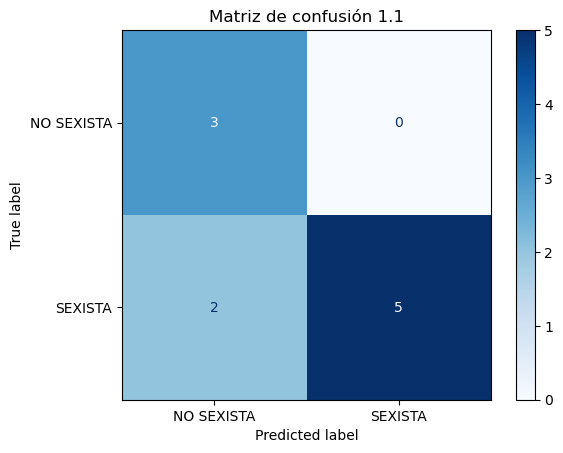


📊 MÉTRICAS SUBTAREA 1.2 (Intención):
              precision    recall  f1-score   support

      DIRECT       1.00      0.67      0.80         6
    REPORTED       1.00      0.50      0.67         2
 JUDGEMENTAL       0.40      1.00      0.57         2

    accuracy                           0.70        10
   macro avg       0.80      0.72      0.68        10
weighted avg       0.88      0.70      0.73        10

Matriz de confusión 1.2:
 [[4 0 2]
 [0 1 1]
 [0 0 2]]


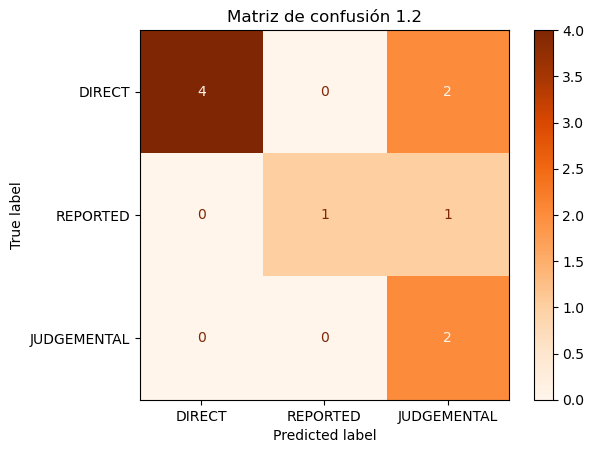

In [52]:
# ...existing code...
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ejemplos inventados para evaluación (puedes ampliar la lista)
test_data = [
    {'text': "Las mujeres no deberían trabajar fuera de casa", 'label_1_1': 1, 'label_1_2': "DIRECT"},
    {'text': "Hoy es un gran día para todos", 'label_1_1': 0, 'label_1_2': "DIRECT"},
    {'text': "Las mujeres son malas conductoras", 'label_1_1': 1, 'label_1_2': "DIRECT"},
    {'text': "Me gusta el fútbol", 'label_1_1': 0, 'label_1_2': "DIRECT"},
    {'text': "Ayer sufrí acoso en el trabajo por ser mujer", 'label_1_1': 1, 'label_1_2': "REPORTED"},
    {'text': "El abuso doméstico es inaceptable", 'label_1_1': 1, 'label_1_2': "JUDGEMENTAL"},
    {'text': "Las mujeres deben quedarse en casa", 'label_1_1': 1, 'label_1_2': "DIRECT"},
    {'text': "No todas las mujeres son iguales", 'label_1_1': 0, 'label_1_2': "DIRECT"},
    {'text': "Me contaron que una amiga fue discriminada", 'label_1_1': 1, 'label_1_2': "REPORTED"},
    {'text': "Critico el machismo en la sociedad", 'label_1_1': 1, 'label_1_2': "JUDGEMENTAL"},
]

# Predicciones para 1.1 (binario) y 1.2 (multiclase)
y_true_1_1, y_pred_1_1 = [], []
y_true_1_2, y_pred_1_2 = [], []

for item in test_data:
    res = hybrid_system.ensemble_prediction(item['text'])
    # 1.1
    pred_1_1 = 1 if res['subtask_1_1']['ensemble']['prediction'] == 'YES' else 0
    y_true_1_1.append(item['label_1_1'])
    y_pred_1_1.append(pred_1_1)
    # 1.2
    pred_1_2 = res['subtask_1_2']['ensemble']['prediction']
    y_true_1_2.append(item['label_1_2'])
    y_pred_1_2.append(pred_1_2)

# Métricas y matriz de confusión para 1.1 (binario)
print("\n📊 MÉTRICAS SUBTAREA 1.1 (Binario):")
print(f"Accuracy:  {accuracy_score(y_true_1_1, y_pred_1_1):.3f}")
print(f"F1-score:  {f1_score(y_true_1_1, y_pred_1_1):.3f}")
print(f"Precision: {precision_score(y_true_1_1, y_pred_1_1):.3f}")
print(f"Recall:    {recall_score(y_true_1_1, y_pred_1_1):.3f}")
cm_1_1 = confusion_matrix(y_true_1_1, y_pred_1_1)
print("Matriz de confusión 1.1:\n", cm_1_1)
try:
    import matplotlib.pyplot as plt
    ConfusionMatrixDisplay(cm_1_1, display_labels=["NO SEXISTA", "SEXISTA"]).plot(cmap=plt.cm.Blues)
    plt.title("Matriz de confusión 1.1")
    plt.show()
except ImportError:
    pass

# Métricas y matriz de confusión para 1.2 (multiclase)
labels_1_2 = ["DIRECT", "REPORTED", "JUDGEMENTAL"]
print("\n📊 MÉTRICAS SUBTAREA 1.2 (Intención):")
print(classification_report(y_true_1_2, y_pred_1_2, labels=labels_1_2))
cm_1_2 = confusion_matrix(y_true_1_2, y_pred_1_2, labels=labels_1_2)
print("Matriz de confusión 1.2:\n", cm_1_2)
try:
    ConfusionMatrixDisplay(cm_1_2, display_labels=labels_1_2).plot(cmap=plt.cm.Oranges)
    plt.title("Matriz de confusión 1.2")
    plt.show()
except ImportError:
    pass
# ...existing